In [19]:
import keras
keras.__version__

'2.2.2'

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18329753727232267042
]


In [21]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [22]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

# Train model

In [25]:
#!pip3 install jupyter-tensorboard
for i in range(10):
    #autoencoder = train_model(x)
    pass

## Training variables

In [137]:

#target_image_size = (64,112)
target_image_size = (32,64)

color_mode='grayscale' # 'grayscale' or 'rgb'

if color_mode=='grayscale':
    target_image_size_3D = (target_image_size[0], target_image_size[1], 1)
else: #then rgb
    target_image_size_3D = (target_image_size[0], target_image_size[1], 3)

batch_size_training = 32
batch_size_validation = 32

# Directories
image_dir_training ='data_with_rotations/train'
image_dir_validation = 'data_with_rotations/validate'
image_dir_testing = 'data_with_rotations/test'

# Training variables
training_steps_per_epoch = 200
training_number_of_epoch = 5
validation_steps = 100

# Model name to save
model_name='autoencoder_foo'

# Model name to load for Testing
model_name_pretrained = model_name

# Encoder model name
model_name_encoder = model_name + '-encoder'

In [ ]:
# Testing variables

In [114]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


from sklearn.metrics import label_ranking_average_precision_score
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Convenience functions

In [115]:
# Unfortunately, matplotlib, cv2, etc only print in greyscale 
#   when you have 3 color axes (RGB) all set to make the image look grey.
#   But Keras loads greyscale images with only a single number (to optimize training, etc)
#   So, we need to convert any Keras greyscale images to have 3 values

def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

## ImageDataGenerators 

In [116]:
# Created the Train and Validation image generators

# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        image_dir_training,
        target_size=target_image_size,
        batch_size=batch_size_training,
        class_mode='input',
        color_mode=color_mode)

validation_generator = validation_datagen.flow_from_directory(
        image_dir_validation,
        target_size=target_image_size,
        batch_size=batch_size_validation,
        class_mode='input',
        color_mode=color_mode)



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.


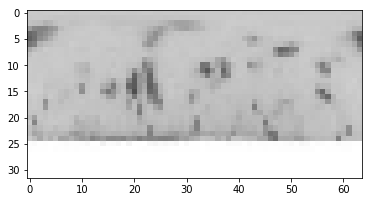

In [117]:
# Create an Sample image generator and get sample images to use throughout all the training for visualization


# Create callback function to use later.
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        'data_with_rotations/test',
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode=color_mode)

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

#
display_image(test_image)


## Define Model for Training - Architecture

In [118]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same', strides=(2,2))(input_img)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2,2))(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    

In [119]:
# Create callback to write sample images to disk
class ProgressCallback(callbacks.Callback):
    
    def __init__(self, sample_image):
        self.sample_image = sample_image
        self.image4d = self.sample_image[None,:] # predict needs a batch of images (shape=4). This adds a dimension  
        
    def on_epoch_end(self, epoch, logs={}):
        
        processed_images = self.model.predict(x=[self.image4d],batch_size=1)
         
        # plot the image and save it
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(self.sample_image)
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [120]:
# Train the model
def train_model(model_to_train):
    progress = ProgressCallback(sample_image=sample_images[0])
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=training_steps_per_epoch,
        epochs=training_number_of_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save(model_name + '.h5')
    
    return model_to_train

In [121]:
#autoencoder.save('autoencoder_8by14by128.h5')

In [122]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded_5/Sigmoid:0' shape=(?, 32, 64, 1) dtype=float32>]


In [123]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 64, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 32, 16)        416       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 16, 32)         4640      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 16, 128)        36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 8, 128)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 8, 16, 128)        0         
__________

In [124]:
# Show encoder output size (before global pooling)
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder_5/MaxPool:0' shape=(?, 4, 8, 128) dtype=float32>

In [125]:
autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/5
200/200 [==============================] - 23s 116ms/step - loss: 0.5266 - val_loss: 0.4984
Epoch 2/5
200/200 [==============================] - 23s 116ms/step - loss: 0.5056 - val_loss: 0.4847
Epoch 3/5
200/200 [==============================] - 24s 122ms/step - loss: 0.5021 - val_loss: 0.4786
Epoch 4/5
200/200 [==============================] - 24s 122ms/step - loss: 0.4994 - val_loss: 0.4748
Epoch 5/5
200/200 [==============================] - 24s 121ms/step - loss: 0.4983 - val_loss: 0.4734


In [126]:
#!pip3 install jupyter-tensorboard
for i in range(3):
    pass
    #autoencoder = train_model(x)

In [144]:
for i in range(50):
    #autoencoder = train_model(x)
    #pass

Epoch 1/5
200/200 [==============================] - 15s 73ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 2/5
200/200 [==============================] - 15s 73ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 3/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4933 - val_loss: 0.4692
Epoch 4/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4923 - val_loss: 0.4688
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4928 - val_loss: 0.4689
Epoch 1/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4928 - val_loss: 0.4687
Epoch 2/5
200/200 [==============================] - 14s 68ms/step - loss: 0.4924 - val_loss: 0.4688
Epoch 3/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4921 - val_loss: 0.4689
Epoch 4/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4927 - val_loss: 0.4689
Epoch 5/5
200/200 [==============================] - 14s 69ms/step - loss: 0.4923 - val_los

200/200 [==============================] - 13s 67ms/step - loss: 0.4894 - val_loss: 0.4662
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4897 - val_loss: 0.4662
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4896 - val_loss: 0.4664
Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4888 - val_loss: 0.4662
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4898 - val_loss: 0.4662
Epoch 3/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4896 - val_loss: 0.4661
Epoch 4/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4900 - val_loss: 0.4661
Epoch 5/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4894 - val_loss: 0.4661
Epoch 1/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4897 - val_loss: 0.4662
Epoch 2/5
200/200 [==============================] - 13s 67ms/step - loss: 0.4893 - val_loss: 0.4661


# Test the model

In [145]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [129]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model(model_name_pretrained + '.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)


Loading model :
Model loaded in:  1.6229913234710693


# Convenience methods

In [140]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16, color_mode='grayscale', target_image_size=(100,100)):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        self.color_mode = color_mode
        self.target_image_size = target_image_size
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode=self.color_mode,
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames   
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
        
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



# Create encoder model

In [141]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)

# save the model to disk for reuse later
encoder.save(model_name_encoder + '.h5')



In [160]:
# Create dictionary with all filenames (keys) and predicted encodings (values)
image_encoding_dict = {}

test_images = all_directory_images_generator(batch_size=16, target_image_size=target_image_size, sourcedir=image_dir_testing)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        image_encoding_dict[names[j]]=encodings[j]
        


# Create dictionary with index integers (keys) and filenames (values)
#   This is needed later for Annoy, since it uses integers as item keys, and we have to map back to a filename
image_filename_dict = {}

i = 0
for key, value in image_encoding_dict.items():
    image_filename_dict[i]=key
    i = i+1



Found 96 images belonging to 1 classes.


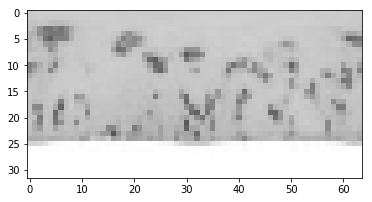

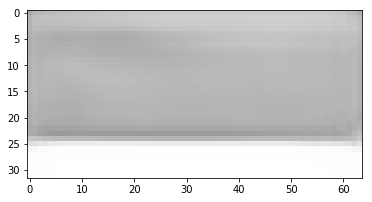

images/229.jpg


In [161]:
# Let's just view a few input images and output images from the autoencoder
#   This includes the decoder part of the autoencoder, so we'll still see an image

next_batch, next_filenames = next(test_images) # Use the test_images defined above
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])



# Get a feel for the outputs

In [153]:
# Load a dataframe from the dictionary
import pandas as pd
df = pd.DataFrame.from_dict(image_encoding_dict, orient='index')

#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
#df.to_csv('96_images_32x64_AvgPool_4x8.csv')

df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
images/229.jpg,0.063860,0.061876,0.003318,0.001059,0.137664,0.026035,0.157502,0.220251,0.004588,0.043392,...,0.108547,0.002679,0.094000,0.054947,0.000800,0.153692,0.260630,0.097797,0.000046,0.0
images/229_196.jpg,0.061175,0.061395,0.004299,0.001173,0.142693,0.025859,0.153336,0.219929,0.005776,0.043340,...,0.107111,0.002866,0.092584,0.055860,0.001859,0.155693,0.258860,0.101504,0.000000,0.0
images/229_262.jpg,0.064669,0.065151,0.003796,0.000969,0.141970,0.026338,0.155338,0.224507,0.006892,0.046671,...,0.107976,0.002814,0.095232,0.058152,0.001369,0.156454,0.258324,0.101251,0.000000,0.0
images/229_45.jpg,0.066213,0.065219,0.003262,0.000917,0.141873,0.026255,0.159294,0.224828,0.006023,0.046024,...,0.108989,0.002559,0.094828,0.057427,0.000766,0.155266,0.258389,0.100806,0.000200,0.0
images/230.jpg,0.064297,0.087374,0.003229,0.000842,0.141790,0.027658,0.167186,0.204662,0.016278,0.038364,...,0.103973,0.002168,0.091411,0.072978,0.001494,0.144040,0.252157,0.090224,0.000561,0.0
images/230_200.jpg,0.062041,0.085786,0.002858,0.000957,0.138780,0.027780,0.163652,0.204705,0.015989,0.038992,...,0.105892,0.002699,0.091202,0.069535,0.002000,0.142054,0.248286,0.088769,0.000571,0.0
images/230_287.jpg,0.065719,0.086530,0.003008,0.000963,0.142330,0.027585,0.168902,0.206164,0.016672,0.038506,...,0.105787,0.002431,0.092920,0.069551,0.001118,0.144666,0.248983,0.090597,0.000585,0.0
images/230_341.jpg,0.065148,0.087338,0.003325,0.000861,0.142006,0.027871,0.169462,0.204312,0.017401,0.036577,...,0.104195,0.002064,0.092337,0.071783,0.001381,0.145346,0.250160,0.089980,0.000643,0.0
images/231.jpg,0.071581,0.097366,0.003933,0.000888,0.141658,0.028710,0.172204,0.203647,0.020500,0.042918,...,0.110702,0.002641,0.097299,0.072244,0.000624,0.137781,0.249561,0.084768,0.001060,0.0
images/231_212.jpg,0.067304,0.096865,0.003365,0.000894,0.141924,0.028557,0.172683,0.205314,0.021374,0.042213,...,0.108037,0.003048,0.095519,0.076211,0.001508,0.137010,0.249802,0.087747,0.000624,0.0


In [154]:
# Look at the simple statistics around the encodings
dfstat = df.describe()
dfstat

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,0.056194,0.055736,0.003460,0.001019,0.145396,0.021683,0.154044,0.217256,0.008745,0.039370,...,0.107435,0.002763,0.089216,0.062928,0.001668,0.152014,0.258444,0.098246,0.000341,0.0
std,0.009226,0.022578,0.000639,0.000137,0.010258,0.006154,0.013481,0.014685,0.007709,0.004402,...,0.009241,0.000749,0.004901,0.007061,0.000617,0.008030,0.008676,0.010257,0.000417,0.0
min,0.037543,0.003434,0.001544,0.000592,0.132864,0.003670,0.121408,0.175295,0.000105,0.031459,...,0.087221,0.000193,0.076068,0.052668,0.000395,0.130735,0.233910,0.066547,0.000000,0.0
25%,0.047556,0.045011,0.003304,0.001004,0.138662,0.020001,0.145802,0.210784,0.002097,0.036558,...,0.104139,0.002254,0.086309,0.056927,0.001230,0.148547,0.255770,0.097237,0.000000,0.0
50%,0.057338,0.053425,0.003591,0.001067,0.141947,0.022605,0.152533,0.220620,0.005885,0.038494,...,0.108815,0.002736,0.089760,0.062966,0.001565,0.154236,0.259945,0.101282,0.000201,0.0
75%,0.063240,0.062389,0.003856,0.001105,0.147884,0.026184,0.163658,0.227334,0.014798,0.043353,...,0.113587,0.003181,0.093034,0.066743,0.002021,0.156638,0.263992,0.104004,0.000475,0.0
max,0.072279,0.097809,0.005121,0.001199,0.174088,0.028710,0.182244,0.236727,0.026965,0.047400,...,0.120841,0.004429,0.098652,0.081771,0.003943,0.164808,0.274113,0.111967,0.001694,0.0


In [155]:
# See how they all cluster
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)
print(km.labels_)

[22 22 22 22 16 16 16 16  1  1  1  1  3  3  3  3 10 10 10 10 14 14 14 14
 19 19 19 19 17 17 17 17 20 20 20 20 15 15 15 15  0  0  0  0 13 13 13 13
 23 23 23 23  5  5  5  5  7  7  7  7 18 18 18 18  9  9  9  9  8  8  8  8
  2  2  2  2  6  6  6  6 21 21 21 21 11 11 11 11 12 12 12 12  4  4  4  4]


In [156]:
# Convert results to a dataframe - note that to get the index / filename, I had to include the first column
results = pd.DataFrame({
    'ignore': df[0],
    'category': km.labels_
})
results

,ignore,category
images/229.jpg,0.063860,22
images/229_196.jpg,0.061175,22
images/229_262.jpg,0.064669,22
images/229_45.jpg,0.066213,22
images/230.jpg,0.064297,16
images/230_200.jpg,0.062041,16
images/230_287.jpg,0.065719,16
images/230_341.jpg,0.065148,16
images/231.jpg,0.071581,1
images/231_212.jpg,0.067304,1


In [157]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
distdf

,images/229.jpg,images/229_196.jpg,images/229_262.jpg,images/229_45.jpg,images/230.jpg,images/230_200.jpg,images/230_287.jpg,images/230_341.jpg,images/231.jpg,images/231_212.jpg,...,images/250_323.jpg,images/250_331.jpg,images/251.jpg,images/251_327.jpg,images/251_355.jpg,images/251_48.jpg,images/252.jpg,images/252_135.jpg,images/252_68.jpg,images/252_75.jpg
images/229.jpg,0.000000,0.023897,0.026898,0.021531,0.103848,0.099526,0.098433,0.102114,0.130917,0.126364,...,0.070474,0.070695,0.220611,0.223973,0.219510,0.223759,0.196995,0.198145,0.208791,0.214448
images/229_196.jpg,0.023897,0.000000,0.021311,0.024288,0.106781,0.102924,0.101667,0.104761,0.133905,0.128627,...,0.075036,0.075483,0.222528,0.225838,0.221550,0.225865,0.200790,0.201942,0.212670,0.217985
images/229_262.jpg,0.026898,0.021311,0.000000,0.019478,0.098231,0.094891,0.092549,0.095842,0.123967,0.118384,...,0.068103,0.067622,0.218867,0.222570,0.218012,0.222132,0.194529,0.195686,0.206864,0.212027
images/229_45.jpg,0.021531,0.024288,0.019478,0.000000,0.100962,0.098010,0.095396,0.098686,0.124329,0.119595,...,0.069628,0.069035,0.219929,0.223388,0.219075,0.223137,0.194704,0.195450,0.206519,0.211832
images/230.jpg,0.103848,0.106781,0.098231,0.100962,0.000000,0.019188,0.016436,0.014121,0.049409,0.043600,...,0.048613,0.049455,0.154138,0.157910,0.153321,0.157032,0.116675,0.119752,0.130407,0.136363
images/230_200.jpg,0.099526,0.102924,0.094891,0.098010,0.019188,0.000000,0.017289,0.022130,0.056361,0.050985,...,0.043917,0.046536,0.154068,0.157727,0.152980,0.156681,0.118546,0.122211,0.132739,0.138930
images/230_287.jpg,0.098433,0.101667,0.092549,0.095396,0.016436,0.017289,0.000000,0.014195,0.053605,0.047959,...,0.046012,0.047539,0.160445,0.164177,0.159538,0.163100,0.122595,0.125834,0.136533,0.142427
images/230_341.jpg,0.102114,0.104761,0.095842,0.098686,0.014121,0.022130,0.014195,0.000000,0.050197,0.044681,...,0.050004,0.050727,0.160559,0.164442,0.159755,0.163539,0.122697,0.125677,0.136466,0.142476
images/231.jpg,0.130917,0.133905,0.123967,0.124329,0.049409,0.056361,0.053605,0.050197,0.000000,0.018836,...,0.075334,0.072848,0.148054,0.151874,0.147841,0.151130,0.106432,0.107784,0.119097,0.123867
images/231_212.jpg,0.126364,0.128627,0.118384,0.119595,0.043600,0.050985,0.047959,0.044681,0.018836,0.000000,...,0.071747,0.068707,0.152253,0.156109,0.151956,0.155446,0.111093,0.112629,0.123955,0.128889


In [158]:
# Show the covariance between the columns - not useful since it's unscaled. :-(
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [159]:
# Show the correlation between the columns (which represent a global pool from the encoder convolutions)
#   Correlation appears high, likely could do some PCA, but seems like tuning the autoencoder should be able to do that
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
corrdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.000000,0.526817,-0.264026,-0.429217,0.036023,0.338823,0.435229,-0.423428,0.517500,0.658379,...,-0.288539,0.037173,0.657056,0.307075,-0.286934,-0.408624,-0.095691,-0.499047,0.148963,NaN
1,0.526817,1.000000,-0.287493,-0.587407,-0.330756,0.743979,0.663396,-0.717279,0.439634,0.269620,...,0.133311,0.161350,0.803569,0.624383,-0.437226,-0.827306,-0.740159,-0.733302,0.556428,NaN
2,-0.264026,-0.287493,1.000000,0.758603,-0.590861,0.318633,0.121390,0.675478,-0.782664,0.105213,...,0.641627,0.211452,0.075434,-0.576769,-0.032186,0.585688,0.474267,0.739513,-0.613133,NaN
3,-0.429217,-0.587407,0.758603,1.000000,-0.402406,-0.004880,-0.081205,0.690179,-0.729248,-0.149411,...,0.501468,0.214168,-0.224295,-0.649866,0.197467,0.690396,0.656406,0.812254,-0.661490,NaN
4,0.036023,-0.330756,-0.590861,-0.402406,1.000000,-0.833148,-0.696198,-0.085019,0.474243,-0.056670,...,-0.873176,-0.321105,-0.522407,0.165393,0.300345,0.053703,-0.042115,-0.258602,0.292705,NaN
5,0.338823,0.743979,0.318633,-0.004880,-0.833148,1.000000,0.804005,-0.256583,-0.161495,0.277335,...,0.646090,0.331690,0.851608,0.121424,-0.451692,-0.396643,-0.300868,-0.170468,0.021059,NaN
6,0.435229,0.663396,0.121390,-0.081205,-0.696198,0.804005,1.000000,-0.368289,0.203191,0.198632,...,0.616246,0.465268,0.736226,0.455552,-0.222405,-0.509818,-0.129959,-0.259836,0.019838,NaN
7,-0.423428,-0.717279,0.675478,0.690179,-0.085019,-0.256583,-0.368289,1.000000,-0.720912,0.151040,...,0.286112,0.028816,-0.350505,-0.676004,0.281699,0.919167,0.656152,0.929128,-0.650570,NaN
8,0.517500,0.439634,-0.782664,-0.729248,0.474243,-0.161495,0.203191,-0.720912,1.000000,0.079372,...,-0.517959,-0.001357,0.122105,0.831076,0.052178,-0.712491,-0.426600,-0.793943,0.582986,NaN
9,0.658379,0.269620,0.105213,-0.149411,-0.056670,0.277335,0.198632,0.151040,0.079372,1.000000,...,-0.052879,0.180716,0.530374,-0.001820,-0.167922,0.017625,-0.019413,-0.072178,-0.015153,NaN


# Annoy for nearest neighbor search

In [164]:
# Create Annoy database file

from annoy import AnnoyIndex

embedding_vector_size = 128

f = embedding_vector_size      # Length of item vector that will be indexed
t = AnnoyIndex(f)  

for i in range(len(image_encoding_dict)):
    t.add_item(i,image_encoding_dict[image_filename_dict[i]])
    
t.build(25) # 25 trees - need to explore what is a good setting here
t.save(model_name + '.ann') # Save the model



True

In [167]:
# Open Annoy database file get example

sample_item_index = 0
nn_count = 6 # count of nearest neighbors to find

u = AnnoyIndex(f)
u.load(model_name + '.ann') # super fast, will just mmap the file

nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



0 - images/229.jpg : 0.0
3 - images/229_45.jpg : 0.014536533504724503
1 - images/229_196.jpg : 0.017257478088140488
2 - images/229_262.jpg : 0.01908612810075283
39 - images/238_62.jpg : 0.026140257716178894
18 - images/233_337.jpg : 0.02679559402167797


In [273]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

0
0


In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')